# Playground

In [1]:
%matplotlib inline

import glob

import matplotlib.pyplot as plt
import numpy as np

import radarkit
import ppc

from style import context_properties

In [2]:
files = sorted(glob.glob('data/*.rkr'))
file = files[-1]

print(f'Selected file {file}')

Selected file data/PX-20230130-173637.867.rkr


In [3]:
rkid = radarkit.open(file)

rkid.configs[0].SQIThreshold = 0.01
rkid.configs[0].SNRThreshold = -3.0

In [9]:
out = rkid.read()

ppc.use(rkid)
out_ppc = rkid.read()

# Built-in compression module can be restored by unsetting user module
radarkit.unset_user_module()

Estimated number of pulses = 29,458    gateCount = 2,659   downSampledGateCount = 1,092


100%|███████████████████████████████████████████████████████████████████████████████████|00:01<00:00


Done
Estimated number of pulses = 29,458    gateCount = 2,659   downSampledGateCount = 1,092


100%|███████████████████████████████████████████████████████████████████████████████████|00:01<00:00


Done


# A-Scope

- Compute the average power of the last `count` raw pulses
- Compute the average power of the last `count` compressed pulses
- Add a `tiny` value to avoid log of 0

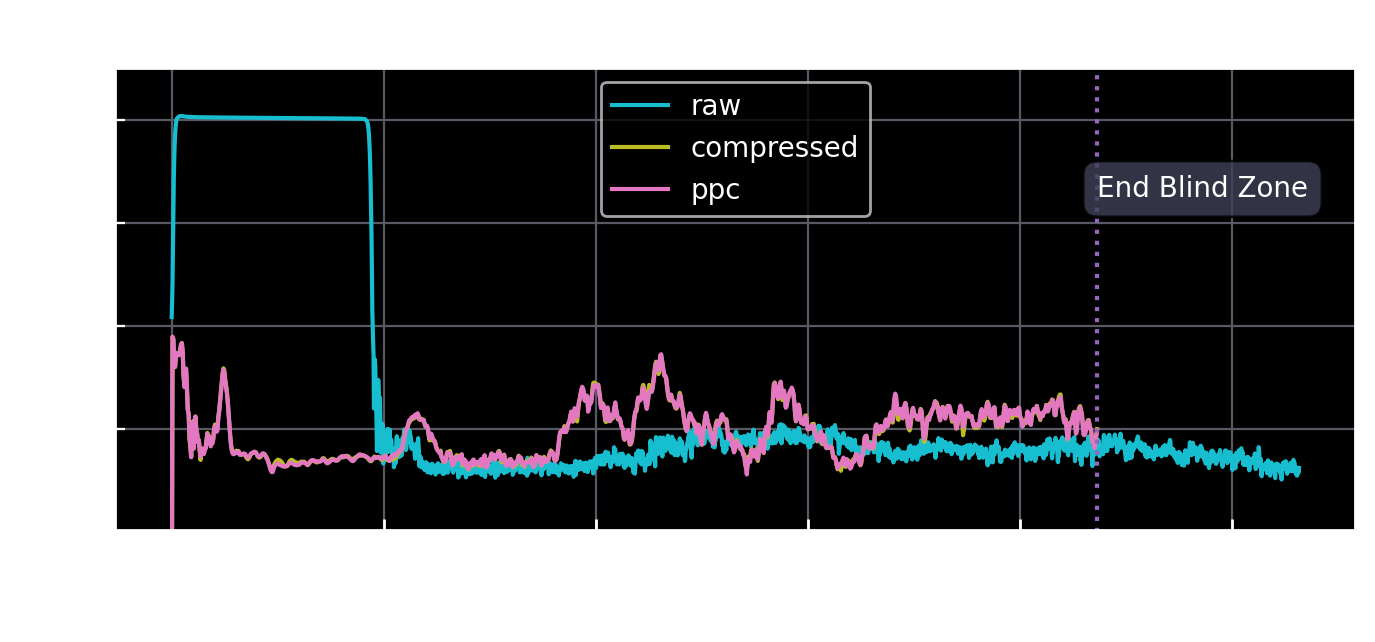

In [10]:
tiny = 1.0e-3

riq = out['riq']
ciq = out['ciq']
piq = out_ppc['ciq']

count = 40
r = np.mean(np.abs(riq[-count:, 0, :]) ** 2, axis=0)
c = np.mean(np.abs(ciq[-count:, 0, :]) ** 2, axis=0)
p = np.mean(np.abs(piq[-count:, 0, :]) ** 2, axis=0)

xr = np.arange(riq.shape[2])
xc = np.arange(ciq.shape[2]) * rkid.desc.pulseToRayRatio
xb = np.array([1, 1]) * xc[-1]

yr = 10 * np.log10(r + tiny)
yc = 10 * np.log10(c + tiny)
yp = 10 * np.log10(p + tiny)

with plt.rc_context(context_properties):
    plt.figure(figsize=(8, 3), dpi=200)
    plt.plot(xr, yr, label='raw')
    plt.plot(xc, yc, label='compressed')
    plt.plot(xc, yp, label='ppc')
    plt.plot(xb, [0, 100], ':')
    plt.text(xb[0], 65, 'End Blind Zone', bbox={
        'boxstyle': 'round, pad=0.5',
        'facecolor': (0.25, 0.25, 0.35, 0.9),
        'alpha': 0.8
    })
    plt.ylim(0.5, 90)
    plt.grid()
    plt.legend()
    plt.xlabel('Range Gates')
    plt.ylabel('Power (dB-ADU)')
    plt.title('A-Scope', fontweight='bold')

# B-Scope

- Select a `count` for number of pulses to compute a radial
- Extract up to `rayCount * count` pulses
- Reindex the array to (gateCount, rayCount, count)
- Compute power, average over the last axis count

In [ ]:
count = 80
rayCount = ciq.shape[0] // count
gateCount = ciq.shape[2]
n = rayCount * count
x = np.reshape(ciq[:n, 0, :], (rayCount, count, -1))
x = np.transpose(x, (2, 0, 1))

r0 = np.mean(np.abs(x) ** 2, axis=2)
r1 = np.mean(x[:, :, 1:] * np.conj(x[:, :, :-1]), axis=2)
r2 = np.mean(x[:, :, 2:] * np.conj(x[:, :, :-2]), axis=2)

In [ ]:
with plt.rc_context(context_properties):
    plt.figure(figsize=(8, 4), dpi=200)
    plt.pcolormesh(10 * np.log10(r0 + tiny), cmap='viridis', vmin=8, vmax=42)
    plt.xlabel('Ray Index')
    plt.ylabel('Gate Index')
    plt.title('B-Scope', fontweight='bold')
    cb = plt.colorbar()
    cb.set_label('dB-ADU')

In [ ]:
with plt.rc_context(context_properties):
    plt.figure(figsize=(8, 4), dpi=200)
    # plt.pcolormesh(np.abs(r1) / (np.abs(r0) + tiny), cmap='viridis')
    # plt.pcolormesh(10 * np.log10(np.abs(r1) + tiny), cmap='viridis', vmin=8, vmax=42)
    plt.pcolormesh(np.angle(r1), cmap='coolwarm')
    # plt.pcolormesh(np.log(np.abs(r1) / np.abs(r2) + tiny), cmap='tab20c')
    plt.xlabel('Ray Index')
    plt.ylabel('Gate Index')
    plt.title('B-Scope', fontweight='bold')
    cb = plt.colorbar()
    cb.set_label('dB-ADU')

## Check the Next Pulse Status

For debuggning purpose, the next pulse header status should be 0

In [ ]:
k = rkid.pulseMachine.contents.pulseIndex.contents.value
pulse = radarkit.RKGetPulseFromBuffer(rkid.pulseMachine.contents.pulseBuffer, k)
print(f'pulses[{k}].header.s = {pulse.contents.header.s}')

In [ ]:
k = 757
pulse = radarkit.RKGetPulseFromBuffer(rkid.pulseMachine.contents.pulseBuffer, k)

In [ ]:
pulse.contents.header.pulseWidthSampleCount

## Retrieve Radar Products

In [ ]:
prods = rkid.get_moment()

In [ ]:
z = np.transpose(prods['Z'])

with plt.rc_context(context_properties):
    plt.figure(figsize=(8, 4), dpi=200)
    plt.pcolormesh(z, cmap='viridis', vmin=2, vmax=42)
    plt.xlabel('Ray Index')
    plt.ylabel('Gate Index')
    plt.title('B-Scope', fontweight='bold')
    cb = plt.colorbar()
    cb.set_label('dBZ')

In [ ]:
radarkit.free()
# plt.close()